# Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)
import pandas as pd
import h5py
import math

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

from keras.utils import Sequence
import keras


2.15.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split

#Data Generator

In [ ]:
class CustomDataLoader(Sequence):
    def __init__(self, file_path, indices, batch_size):
        self.file_path = file_path
        self.indices = indices
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]
        batch_indices = np.sort(batch_indices)

        # Load data from file based on batch indices
        imgs,labels = self.load_data(batch_indices)

        # Preprocess data
        imgs = self.process_data(imgs)

        return imgs, labels

    def load_data(self, batch_indices):
        # Load rows corresponding to batch_indices from the file
        with h5py.File(self.file_path, 'r') as f:
          data = f['jet'][batch_indices]
        labels = np.ones(len(batch_indices))

        return data,labels

    def process_data(self, data):

        return data / 255.

    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

In [ ]:
file_path = 'Dataset_Specific_Unlabelled.h5'

batch_size = 64
indices = np.arange(60000)
train_idx = indices[:int(len(indices)*0.8)]
val_idx = indices[int(len(indices)*0.8):]

train_generator = CustomDataLoader(file_path, train_idx, batch_size)
val_generator = CustomDataLoader(file_path, val_idx, batch_size)

del indices
del train_idx
del val_idx

# SimCLR Pre-Training

In [ ]:
class ContrastiveLoss(tf.keras.losses.Loss):
    """
    Contrastive loss called InfoNceLoss as in SimCLR paper.

    Differently from the paper images are concatenated along the batch axis.
    Consequently positive pairs are located on the lower and upper diagonal defined by the batch size number.

    """
    def __init__(self, temperature=0.5):
      super().__init__()
      self.temperature = temperature


    def call(self, y_true, y_pred):

      batch_size = int(tf.shape(y_pred)[0]/2)

      x_norm = tf.math.l2_normalize(y_pred, axis=1)
      sim_mat = tf.matmul( x_norm, tf.transpose(x_norm) )

      sim_ij = tf.linalg.diag_part(sim_mat, k = batch_size)
      sim_ji = tf.linalg.diag_part(sim_mat, k = batch_size)

      positives = tf.concat([sim_ij, sim_ji], axis=0)
      nominator = tf.math.exp(positives / self.temperature)

      mask = tf.ones((2*batch_size, 2*batch_size))
      mask = tf.linalg.set_diag(mask, tf.zeros(2*batch_size))

      denominator = mask * tf.math.exp(sim_mat / self.temperature)

      return -1.0 * tf.math.reduce_mean( tf.math.log(nominator/tf.math.reduce_sum(denominator, axis=1)) )

The encoder is a ResNet model. The two distributions of augmentations are made up of random flips, translations and crops. In the end images are resized to the original shape

In [ ]:
class ResNetBlock(tfkl.Layer):
    def __init__(self, filters1, filters2, groups=32, downsample=True, use_norm=True, activation='relu', **kwargs):
        super(ResNetBlock, self).__init__(**kwargs)

        self.use_norm = use_norm
        self.activation = activation
        self.downsample = downsample

        # ConvLayer1
        self.conv1 = tfkl.Conv2D(filters1, kernel_size=1, strides=1, padding='same')

        # BatchNorm1
        if use_norm:
            self.bn1 = tfkl.LayerNormalization()
        self.activation1 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

        # ConvLayer2
        self.conv2 = tfkl.Conv2D(filters2, kernel_size=3, padding='same')

        # BatchNorm2
        if use_norm:
            self.bn2 = tfkl.LayerNormalization()
        self.activation2 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

        # Shortcut connection
        if self.downsample:
            self.conv4 = tfkl.Conv2D(filters2, kernel_size=1, strides=1, activation='relu',padding='same')
            self.bn4 = tfkl.LayerNormalization()
        self.shortcut = tfkl.Add()
        self.activation3 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

    def call(self, inputs, **kwargs):
        x = self.conv1(inputs)
        if self.use_norm:
            x = self.bn1(x)
        x = self.activation1(x)

        x = self.conv2(x)
        if self.use_norm:
            x = self.bn2(x)
        x = self.activation2(x)

        if self.downsample:
            inputs = self.conv4(inputs)
            inputs = self.bn4(inputs)

        shortcut = self.shortcut([inputs, x])
        return self.activation3(shortcut)

class ResNet(tfk.Model):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)

    blocks = [
        tfkl.Conv2D(8,3,activation='relu'),
        tfkl.Dropout(0.1),
        ResNetBlock(16,64,downsample=True,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(32,128,downsample=True,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(64,256,downsample=True,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(128,512,downsample=True,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(256,512,downsample=True,use_norm=True, activation='relu'),
        tfkl.GlobalAveragePooling2D()
    ]

    self.network = tfk.Sequential(blocks)

  def call(self,x):
    x = self.network(x)
    return x

In [ ]:
class AugmentationLayer(tfkl.Layer):
  def __init__(self,**kwargs):
    super(AugmentationLayer, self).__init__(**kwargs)

    self.layers = [
        tfkl.RandomFlip(),
        tfkl.RandomCrop(50,50),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.Resizing(125,125)
    ]

  def call(self, inputs, training=True):

    x = inputs
    for layer in self.layers:
      x = layer(x,training=training)

    return x

In [ ]:
def Contrastive_model(input_shape = (125,125,8)):

    augmentation0 = AugmentationLayer(name='augmentation_0')
    augmentation1 = AugmentationLayer(name='augmentation_1')

    encoder = ResNet()
    tau = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32, name="temperature_parameter")

    proj_head = tfk.Sequential([
        tfkl.Dense(256,activation='relu'),
        tfkl.Dense(128)
    ], name='projection_head')

    input = tfk.Input(shape=input_shape)

    x0 = augmentation0(input)
    x1 = augmentation1(input)

    x0 = encoder(x0)
    x1 = encoder(x1)

    x0 = proj_head(x0)
    x1 = proj_head(x1)

    x = tfkl.Concatenate(axis=0)([x0, x1])

    model = tfk.Model(inputs=input, outputs=x)
    return model, tau

In [ ]:
contrastive_model, tau = Contrastive_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 125, 125, 8)]        0         []                            
                                                                                                  
 augmentation_0 (Augmentati  (None, 125, 125, 8)          0         ['input_1[0][0]']             
 onLayer)                                                                                         
                                                                                                  
 augmentation_1 (Augmentati  (None, 125, 125, 8)          0         ['input_1[0][0]']             
 onLayer)                                                                                         
                                                                                              

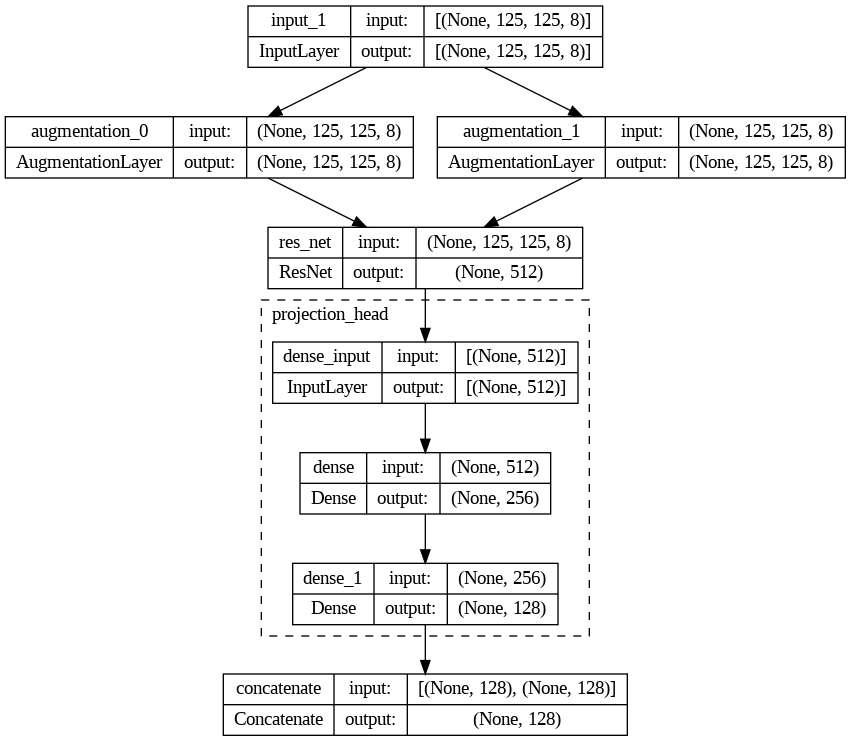

In [ ]:
contrastive_model.summary()
tfk.utils.plot_model(contrastive_model, expand_nested=True, show_shapes=True)

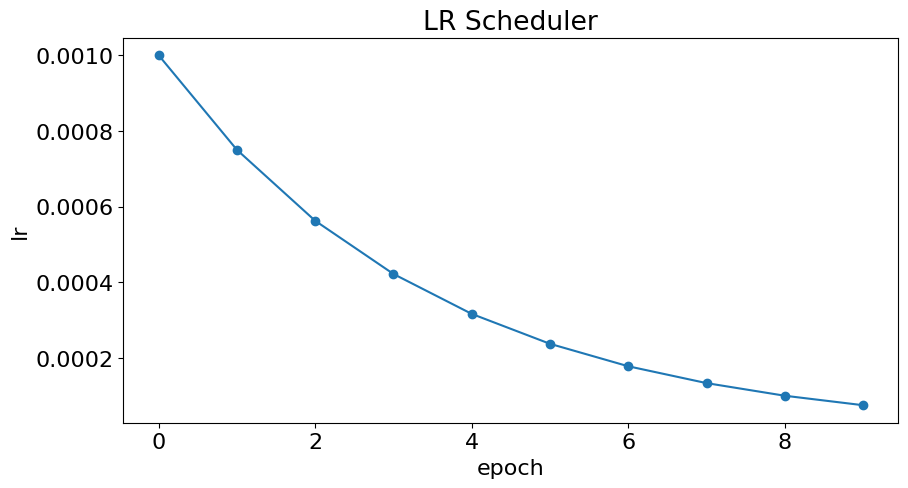

In [ ]:
#batch_size = 64
epochs = 10

def get_lr_callback(batch_size=32, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 1e-3, 1e-3, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 0, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tfk.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode='exp', epochs=epochs, plot=True)
callbacks = [lr_cb]

In [ ]:
learning_rate = 1e-5
optimizer = tfk.optimizers.AdamW(learning_rate)
loss = ContrastiveLoss(temperature=tau)

contrastive_model.compile(optimizer=optimizer, loss=loss)

In [ ]:
history = contrastive_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=int(len(train_generator)/2),
    validation_data=val_generator,
    validation_steps=int(len(val_generator)/2),
    callbacks = callbacks
).history

Epoch 1/10
375/375 [==============================] - 522s 1s/step - loss: 4.6344 - val_loss: 4.2607 - lr: 0.0010
Epoch 2/10
375/375 [==============================] - 439s 1s/step - loss: 4.4508 - val_loss: 4.6503 - lr: 7.5025e-04
Epoch 3/10
375/375 [==============================] - 440s 1s/step - loss: 4.3349 - val_loss: 4.8290 - lr: 5.6294e-04
Epoch 4/10
375/375 [==============================] - 440s 1s/step - loss: 4.2641 - val_loss: 4.8240 - lr: 4.2245e-04
Epoch 5/10
375/375 [==============================] - 440s 1s/step - loss: 4.2488 - val_loss: 4.7559 - lr: 3.1709e-04
Epoch 6/10
375/375 [==============================] - 440s 1s/step - loss: 4.2347 - val_loss: 4.7150 - lr: 2.3807e-04
Epoch 7/10
375/375 [==============================] - 440s 1s/step - loss: 4.2256 - val_loss: 4.6921 - lr: 1.7880e-04
Epoch 8/10
375/375 [==============================] - 440s 1s/step - loss: 4.2199 - val_loss: 4.7220 - lr: 1.3435e-04
Epoch 9/10
375/375 [==============================] - 440s 1

In [ ]:
contrastive_model.layers

In [ ]:
pretraining_model = tfk.Sequential([
    contrastive_model.layers[0],
    contrastive_model.layers[3],
    contrastive_model.layers[4],
])

In [ ]:
pretraining_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_1 (ResNet)          (None, 512)               2582808   
                                                                 
 projection_head (Sequentia  (None, 128)               164224    
 l)                                                              
                                                                 
Total params: 2747032 (10.48 MB)
Trainable params: 2747032 (10.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
save = False

if save:
  pretraining_model.save('pretraining_model_simCLR')

# VigReg Pre-training

In [ ]:
class ContrastiveLoss2(tf.keras.losses.Loss):
    """
    Contrastive loss as in VicReg paper.

    It is made up of 3 terms to prevent informational collapse:
      - Invariance
      - Variance
      - Covariance

    The last two are applied to each branches of the network.

    """
    def __init__(self):
      super().__init__()

    def call(self, y_true, y_pred):

      batch_size = tf.shape(y_pred)[0] // 2
      z1 = y_pred[:batch_size]
      z2 = y_pred[batch_size:]

      l1 = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(z1-z2), axis=1))

      l2_1 = tf.math.reduce_mean(tf.maximum(1 - tf.math.reduce_std(z1, axis=0),0) )
      l2_2 = tf.math.reduce_mean(tf.maximum(1 - tf.math.reduce_std(z2, axis=0),0) )

      z_mean_1 = tf.math.reduce_mean(z1, axis=0)
      z_mean_2 = tf.math.reduce_mean(z2, axis=0)

      C_1 = z1 - z_mean_1
      C_1 = tf.matmul(C_1, C_1, transpose_a=True) / tf.cast(tf.shape(z1)[0] - 1, tf.float32)
      C_2 = z2 - z_mean_2
      C_2 = tf.matmul(C_2, C_2, transpose_a=True) / tf.cast(tf.shape(z2)[0] - 1, tf.float32)

      diagonal_mask = tf.eye(tf.shape(C_1)[0], dtype=tf.bool)
      off_diagonal_mask = tf.logical_not(diagonal_mask)

      off_diagonal_elements_1 = tf.boolean_mask(C_1, off_diagonal_mask)
      off_diagonal_elements_2 = tf.boolean_mask(C_2, off_diagonal_mask)

      l3_1 = tf.math.reduce_mean(off_diagonal_elements_1)
      l3_2 = tf.math.reduce_mean(off_diagonal_elements_2)

      return l1 + l2_1 + l2_2 + l3_1 + l3_2

In [ ]:
class ResNetBlock(tfkl.Layer):
    def __init__(self, filters1, filters2, groups=32, downsample=True, use_norm=True, activation='relu', **kwargs):
        super(ResNetBlock, self).__init__(**kwargs)

        self.use_norm = use_norm
        self.activation = activation
        self.downsample = downsample

        # ConvLayer1
        self.conv1 = tfkl.Conv2D(filters1, kernel_size=1, strides=1, padding='same')

        # BatchNorm1
        if use_norm:
            self.bn1 = tfkl.LayerNormalization()
        self.activation1 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

        # ConvLayer2
        self.conv2 = tfkl.Conv2D(filters2, kernel_size=3, padding='same')

        # BatchNorm2
        if use_norm:
            self.bn2 = tfkl.LayerNormalization()
        self.activation2 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

        # Shortcut connection
        if self.downsample:
            self.conv4 = tfkl.Conv2D(filters2, kernel_size=1, strides=1, activation='relu',padding='same')
            self.bn4 = tfkl.LayerNormalization()
        self.shortcut = tfkl.Add()
        self.activation3 = tfkl.ReLU() if activation == 'relu' else tf.keras.layers.Activation(activation)

    def call(self, inputs, **kwargs):
        x = self.conv1(inputs)
        if self.use_norm:
            x = self.bn1(x)
        x = self.activation1(x)

        x = self.conv2(x)
        if self.use_norm:
            x = self.bn2(x)
        x = self.activation2(x)

        if self.downsample:
            inputs = self.conv4(inputs)
            inputs = self.bn4(inputs)

        shortcut = self.shortcut([inputs, x])
        return self.activation3(shortcut)

class ResNet(tfk.Model):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)

    blocks = [
        tfkl.Conv2D(8,3,activation='relu'),
        tfkl.Dropout(0.1),
        ResNetBlock(16,64,downsample=True,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(32,128,downsample=True,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(64,256,downsample=True,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(128,512,downsample=True,use_norm=True, activation='relu'),
        tfkl.MaxPool2D(),
        tfkl.Dropout(0.1),
        ResNetBlock(256,512,downsample=True,use_norm=True, activation='relu'),
        tfkl.GlobalAveragePooling2D()
    ]

    self.network = tfk.Sequential(blocks)

  def call(self,x):
    x = self.network(x)
    return x

In [ ]:
pip install --upgrade keras-cv

In [ ]:
import keras_cv

In [ ]:
class AugmentationLayer(tfkl.Layer):
  def __init__(self,**kwargs):
    super(AugmentationLayer, self).__init__(**kwargs)

    self.layers = [
        tfkl.RandomCrop(50,50),
        tfkl.RandomFlip(),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.Resizing(125,125),
        keras_cv.layers.RandomCutout(0.2, 0.2, fill_mode="gaussian_noise"),
    ]

  def call(self, inputs, training=True):

    x = inputs
    for layer in self.layers:
      x = layer(x,training=training)

    return x

In [ ]:
def Contrastive_model(input_shape = (125,125,8)):

    augmentation0 = AugmentationLayer(name='augmentation_0')
    augmentation1 = AugmentationLayer(name='augmentation_1')

    encoder = ResNet()

    proj_head = tfk.Sequential([
        tfkl.Dense(256,activation='relu'),
        tfkl.Dense(128)
    ], name='projection_head')

    input = tfk.Input(shape=input_shape)

    x0 = augmentation0(input)
    x1 = augmentation1(input)

    x0 = encoder(x0)
    x1 = encoder(x1)

    x0 = proj_head(x0)
    x1 = proj_head(x1)

    x = tfkl.Concatenate(axis=0)([x0, x1])

    model = tfk.Model(inputs=input, outputs=x)
    return model

In [ ]:
contrastive_model = Contrastive_model()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 125, 125, 8)]        0         []                            
                                                                                                  
 augmentation_0 (Augmentati  (None, 125, 125, 8)          0         ['input_11[0][0]']            
 onLayer)                                                                                         
                                                                                                  
 augmentation_1 (Augmentati  (None, 125, 125, 8)          0         ['input_11[0][0]']            
 onLayer)                                                                                         
                                                                                           

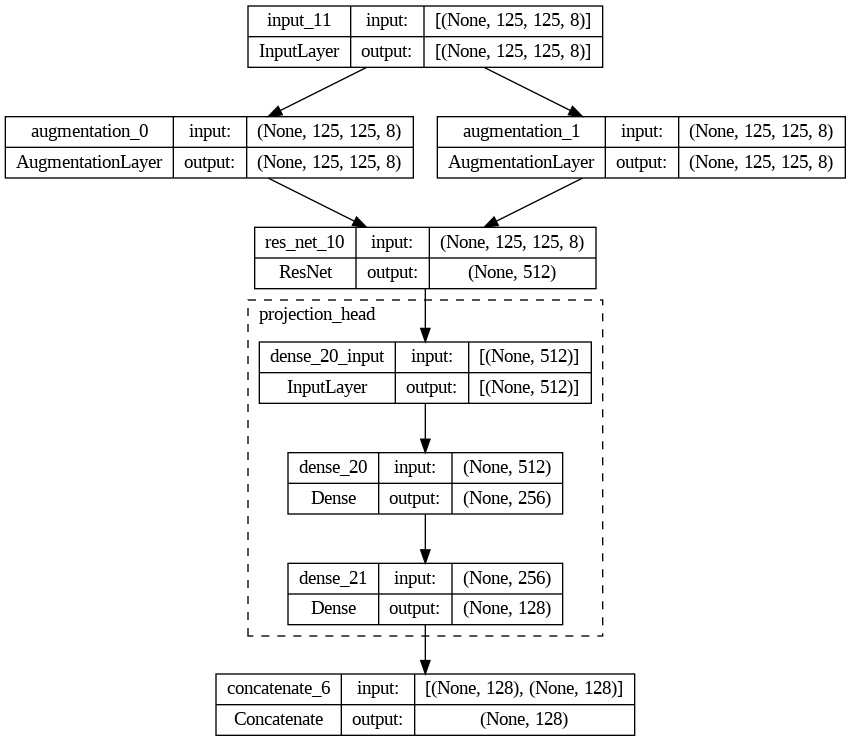

In [ ]:
contrastive_model.summary()
tfk.utils.plot_model(contrastive_model, expand_nested=True, show_shapes=True)

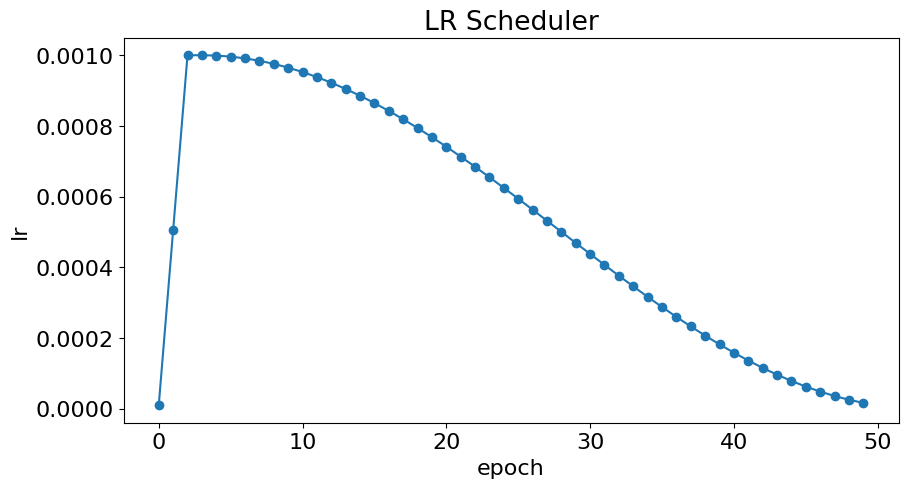

In [ ]:
#batch_size = 64
epochs = 50

def get_lr_callback(batch_size=32, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 1e-5, 1e-3, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 1, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tfk.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode='cos', epochs=epochs, plot=True)
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=2, mode='min', patience=5, restore_best_weights=True)
callbacks = [early_stopping, lr_cb]

In [ ]:
learning_rate = 1e-5
optimizer = tfk.optimizers.AdamW(learning_rate)
loss = ContrastiveLoss2()

contrastive_model.compile(optimizer=optimizer, loss=loss)

In [ ]:
history = contrastive_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=int(len(train_generator)/4),
    validation_data=val_generator,
    validation_steps= len(val_generator),
    callbacks = callbacks
).history

Epoch 1/50
187/187 [==============================] - 314s 2s/step - loss: 2.3997 - val_loss: 1.9726 - lr: 1.0000e-05
Epoch 2/50
187/187 [==============================] - 290s 2s/step - loss: 2.0074 - val_loss: 1.9936 - lr: 5.0500e-04
Epoch 3/50
187/187 [==============================] - 290s 2s/step - loss: 1.9927 - val_loss: 1.9669 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - 290s 2s/step - loss: 1.9898 - val_loss: 1.9826 - lr: 0.0010
Epoch 5/50
187/187 [==============================] - 289s 2s/step - loss: 1.9889 - val_loss: 1.9776 - lr: 9.9901e-04
Epoch 6/50
187/187 [==============================] - 290s 2s/step - loss: 1.9890 - val_loss: 1.9761 - lr: 9.9606e-04
Epoch 7/50
187/187 [==============================] - 290s 2s/step - loss: 1.9884 - val_loss: 1.9745 - lr: 9.9115e-04
Epoch 8/50
187/187 [==============================] - 290s 2s/step - loss: 1.9878 - val_loss: 1.9779 - lr: 9.8431e-04


In [ ]:
contrastive_model.layers

In [ ]:
pretraining_model = tfk.Sequential([
    contrastive_model.layers[0],
    contrastive_model.layers[3],
    contrastive_model.layers[4],
])

In [ ]:
save = False

if save:
  pretraining_model.save('pretraining_model_VicReg')

#Fine tuning from SimCLR pre-training

In [ ]:
class CustomDataLoader2(Sequence):
    def __init__(self, file_path, indices, batch_size):
        self.file_path = file_path
        self.indices = indices
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]
        batch_indices = np.sort(batch_indices)

        # Load data from file based on batch indices
        imgs,labels = self.load_data(batch_indices)

        # Preprocess data
        imgs = self.process_data(imgs)

        return imgs, labels

    def load_data(self, batch_indices):
        # Load rows corresponding to batch_indices from the file
        with h5py.File(self.file_path, 'r') as f:
          data = f['jet'][batch_indices]
          labels = f['Y'][batch_indices].astype(int)

        return data,labels

    def process_data(self, data):

        return data / 255.

    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

In [ ]:
file_path = 'Dataset_Specific_labelled.h5'

batch_size = 64
indices = np.arange(10000)

train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=seed)
val_idx, test_idx = train_test_split(val_idx, test_size=0.2, random_state=seed)

train_generator = CustomDataLoader2(file_path, train_idx, batch_size)
val_generator = CustomDataLoader2(file_path, val_idx, batch_size)
test_generator = CustomDataLoader2(file_path, test_idx, batch_size)

del indices
del train_idx
del val_idx
del test_idx

In [ ]:
encoder = tfk.models.load_model('pretraining_model_simCLR')

input = tfk.Input(shape=(125,125,8))
x = encoder(input)
x = tfkl.Dropout(0.1)(x)
x = tfkl.Dense(1,activation='sigmoid')(x)

model = tfk.Model(inputs=input,outputs=x)

In [ ]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 125, 125, 8)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 128)               2747032   
                                                                 
 dropout_58 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2747161 (10.48 MB)
Trainable params: 2747161 (10.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#batch_size = 64
epochs = 30

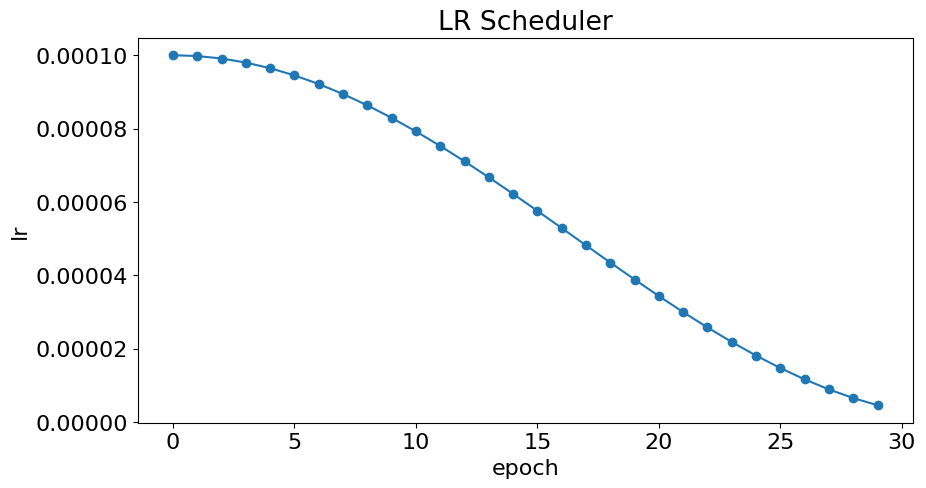

In [ ]:
def get_lr_callback(batch_size=32, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 1e-4, 1e-4, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 0, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tfk.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode='cos', epochs=epochs, plot=True)
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True)
callbacks = [early_stopping, lr_cb]

In [ ]:
# Define optimizer and metrics
learning_rate = 1e-4
optimizer = tfk.optimizers.AdamW(learning_rate)
loss = tfk.losses.BinaryCrossentropy()
metrics = ['accuracy','AUC']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = callbacks
).history

Epoch 1/30
125/125 [==============================] - 82s 580ms/step - loss: 0.8480 - accuracy: 0.5011 - auc: 0.5034 - val_loss: 0.6918 - val_accuracy: 0.5263 - val_auc: 0.5110 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 72s 574ms/step - loss: 0.6921 - accuracy: 0.5215 - auc: 0.5341 - val_loss: 0.6730 - val_accuracy: 0.5763 - val_auc: 0.6619 - lr: 9.9776e-05
Epoch 3/30
125/125 [==============================] - 72s 574ms/step - loss: 0.6230 - accuracy: 0.6666 - auc: 0.7251 - val_loss: 0.5747 - val_accuracy: 0.7031 - val_auc: 0.8125 - lr: 9.9105e-05
Epoch 4/30
125/125 [==============================] - 72s 575ms/step - loss: 0.5068 - accuracy: 0.7701 - auc: 0.8367 - val_loss: 0.4521 - val_accuracy: 0.8163 - val_auc: 0.8770 - lr: 9.7995e-05
Epoch 5/30
125/125 [==============================] - 72s 574ms/step - loss: 0.4472 - accuracy: 0.8026 - auc: 0.8739 - val_loss: 0.4036 - val_accuracy: 0.8219 - val_auc: 0.9016 - lr: 9.6454e-05
Epoch 6/30
125/125 [==========

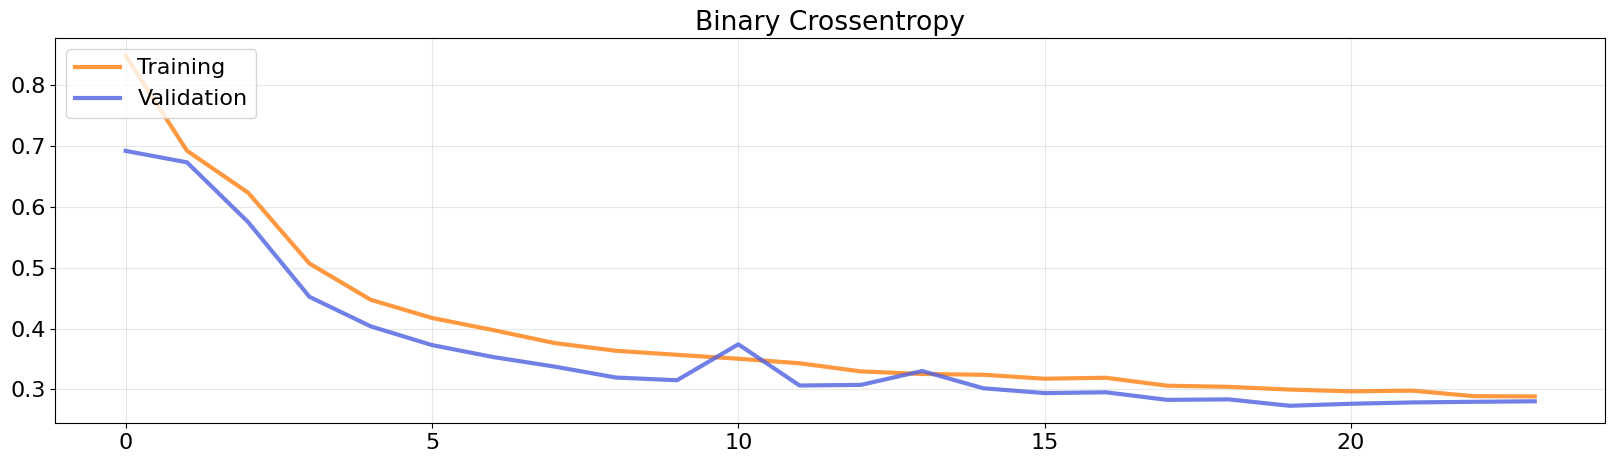

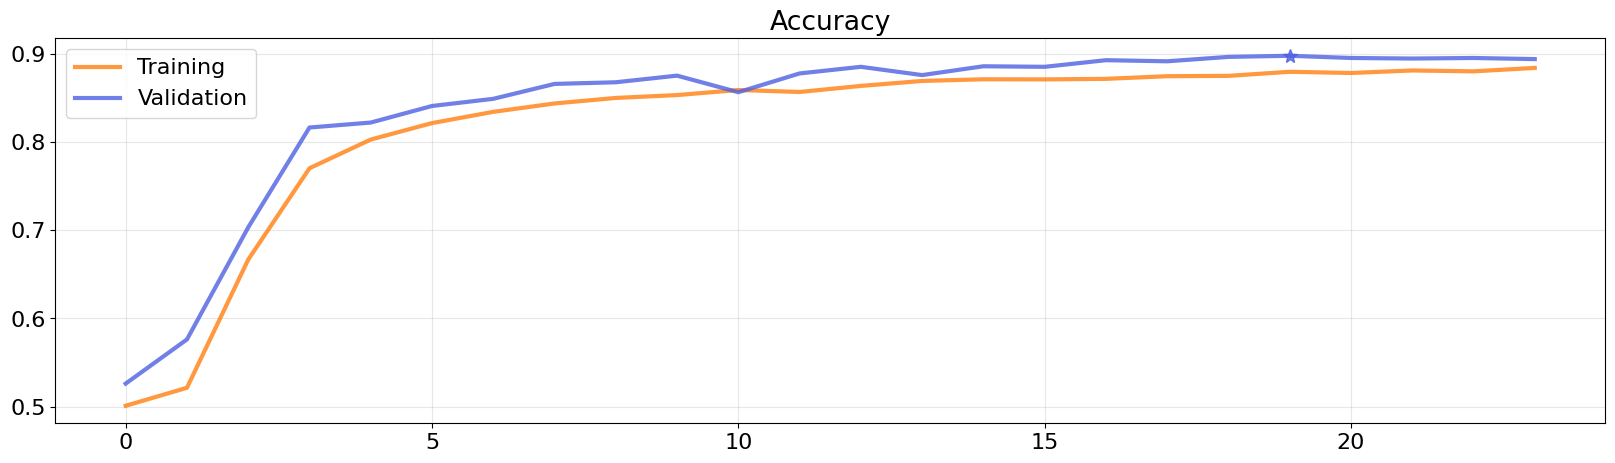

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
out = model.evaluate(test_generator,steps=len(test_generator))

7/7 [==============================] - 2s 206ms/step - loss: 0.3429 - accuracy: 0.8600 - auc: 0.9325


In [ ]:
save = False

if save:
  model.save('finetuning_model_sim')

#Fine tuning from VicReg pre-training

In [ ]:
class CustomDataLoader2(Sequence):
    def __init__(self, file_path, indices, batch_size):
        self.file_path = file_path
        self.indices = indices
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]
        batch_indices = np.sort(batch_indices)

        # Load data from parquet file based on batch indices
        imgs,labels = self.load_data(batch_indices)

        # Preprocess data
        imgs = self.process_data(imgs)

        return imgs, labels

    def load_data(self, batch_indices):
        # Load rows corresponding to batch_indices from the file
        with h5py.File(self.file_path, 'r') as f:
          data = f['jet'][batch_indices]
          labels = f['Y'][batch_indices].astype(int)

        return data,labels

    def process_data(self, data):

        return data / 255.

    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

In [ ]:
file_path = 'Dataset_Specific_labelled.h5'

batch_size = 64
indices = np.arange(10000)

train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=seed)
val_idx, test_idx = train_test_split(val_idx, test_size=0.2, random_state=seed)

train_generator = CustomDataLoader2(file_path, train_idx, batch_size)
val_generator = CustomDataLoader2(file_path, val_idx, batch_size)
test_generator = CustomDataLoader2(file_path, test_idx, batch_size)

del indices
del train_idx
del val_idx
del test_idx

In [ ]:
encoder = tfk.models.load_model('pretraining_model_VicReg')

input = tfk.Input(shape=(125,125,8))
x = encoder(input)
x = tfkl.Dropout(0.1)(x)
x = tfkl.Dense(1,activation='sigmoid')(x)

model = tfk.Model(inputs=input,outputs=x)

In [ ]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 125, 125, 8)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 128)               2747032   
                                                                 
 dropout_59 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2747161 (10.48 MB)
Trainable params: 2747161 (10.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#batch_size = 64
epochs = 30

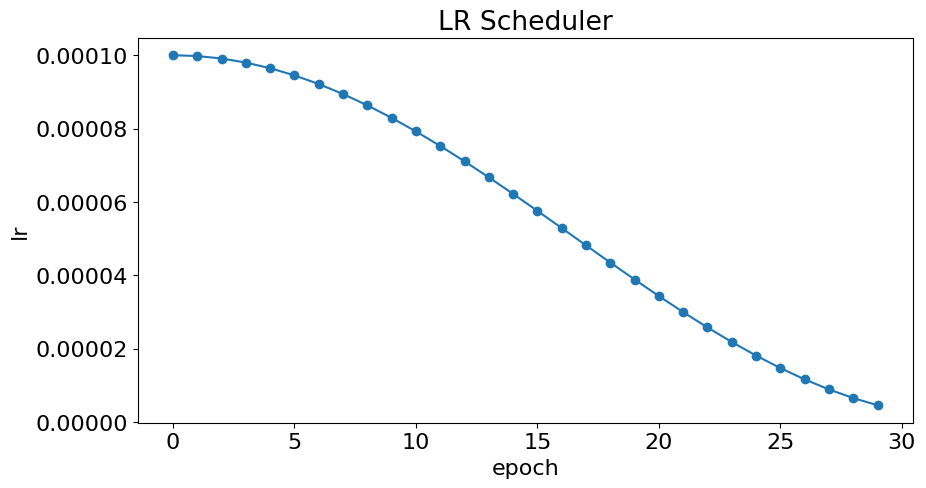

In [ ]:
def get_lr_callback(batch_size=32, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 1e-4, 1e-4, 1e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 0, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tfk.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode='cos', epochs=epochs, plot=True)
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True)
callbacks = [early_stopping, lr_cb]

In [ ]:
# Define optimizer and metrics
learning_rate = 1e-4
optimizer = tfk.optimizers.AdamW(learning_rate)
loss = tfk.losses.BinaryCrossentropy()
metrics = ['accuracy','AUC']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = callbacks
).history

Epoch 1/30
125/125 [==============================] - 82s 585ms/step - loss: 0.7106 - accuracy: 0.5061 - auc: 0.5043 - val_loss: 0.6893 - val_accuracy: 0.5288 - val_auc: 0.5810 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 72s 576ms/step - loss: 0.6828 - accuracy: 0.5600 - auc: 0.5851 - val_loss: 0.5669 - val_accuracy: 0.7231 - val_auc: 0.8473 - lr: 9.9776e-05
Epoch 3/30
125/125 [==============================] - 72s 576ms/step - loss: 0.4976 - accuracy: 0.7707 - auc: 0.8408 - val_loss: 0.4484 - val_accuracy: 0.8050 - val_auc: 0.8803 - lr: 9.9105e-05
Epoch 4/30
125/125 [==============================] - 72s 574ms/step - loss: 0.4523 - accuracy: 0.7975 - auc: 0.8695 - val_loss: 0.4074 - val_accuracy: 0.8250 - val_auc: 0.8996 - lr: 9.7995e-05
Epoch 5/30
125/125 [==============================] - 72s 575ms/step - loss: 0.4169 - accuracy: 0.8205 - auc: 0.8898 - val_loss: 0.4166 - val_accuracy: 0.8269 - val_auc: 0.9145 - lr: 9.6454e-05
Epoch 6/30
125/125 [==========

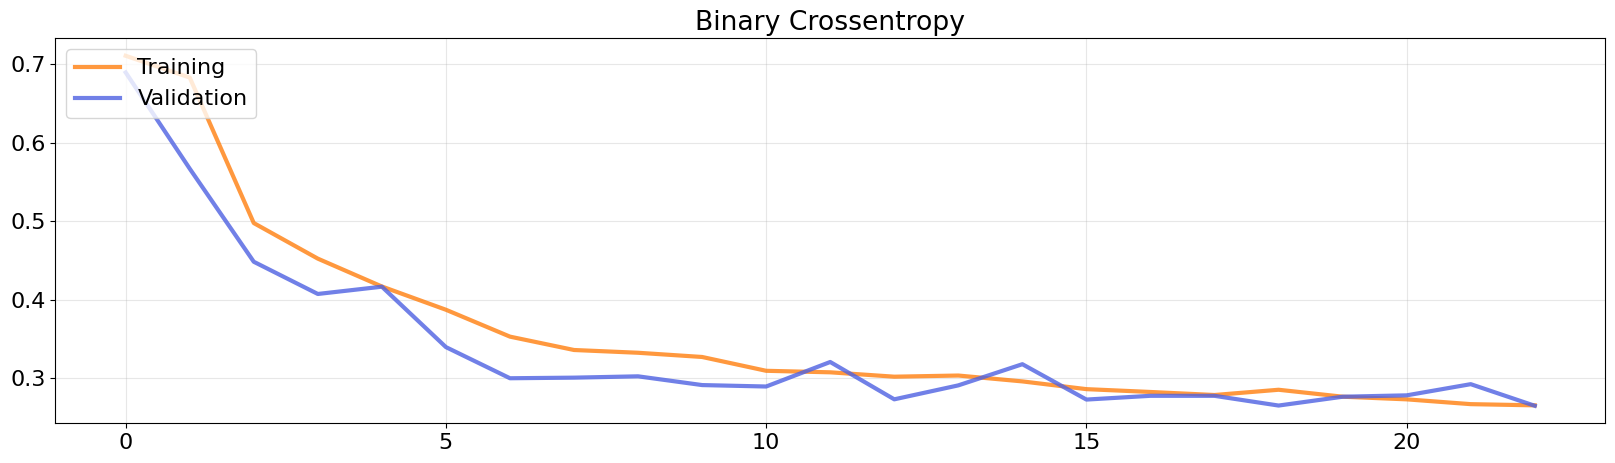

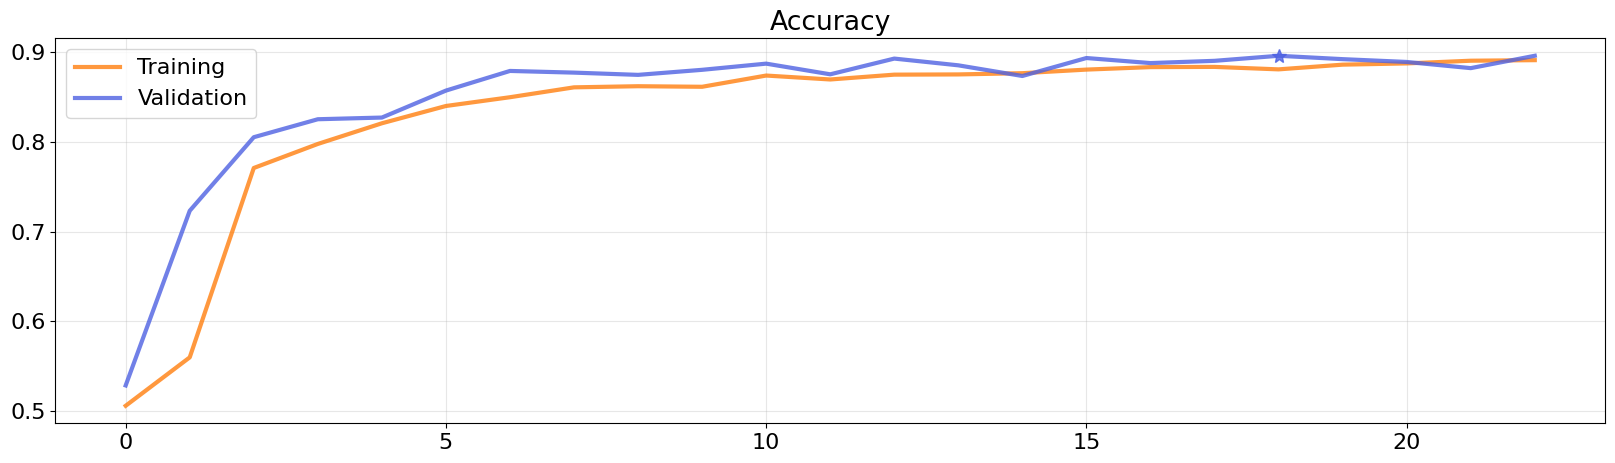

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
out = model.evaluate(test_generator,steps=len(test_generator))

7/7 [==============================] - 2s 206ms/step - loss: 0.3294 - accuracy: 0.8550 - auc: 0.9339


In [ ]:
save = False

if save:
  model.save('finetuning_model_VicReg2')

# VGG

Let's train a VGG model from scratch for comparison

In [ ]:
class CustomDataLoader2(Sequence):
    def __init__(self, file_path, indices, batch_size):
        self.file_path = file_path
        self.indices = indices
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]
        batch_indices = np.sort(batch_indices)

        # Load data from parquet file based on batch indices
        imgs,labels = self.load_data(batch_indices)

        # Preprocess data
        imgs = self.process_data(imgs)

        return imgs, labels

    def load_data(self, batch_indices):
        # Load rows corresponding to batch_indices from the parquet file
        with h5py.File(self.file_path, 'r') as f:
          data = f['jet'][batch_indices]
          labels = f['Y'][batch_indices].astype(int)

        return data,labels

    def process_data(self, data):

        return data / 255.

    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

In [ ]:
file_path = '/content/drive/Othercomputers/Il mio MacBook Pro/Gsoc2024/Dataset_Specific_labelled.h5'

batch_size = 64
indices = np.arange(10000)

train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=seed)
val_idx, test_idx = train_test_split(val_idx, test_size=0.2, random_state=seed)

train_generator = CustomDataLoader2(file_path, train_idx, batch_size)
val_generator = CustomDataLoader2(file_path, val_idx, batch_size)
test_generator = CustomDataLoader2(file_path, test_idx, batch_size)

del indices
del train_idx
del val_idx
del test_idx

In [ ]:
def get_VGG_model(input_shape=(125,125,8),rate=0.1):

  input_layer = tfk.Input(shape=input_shape)

  x = tfkl.Conv2D(8,7,padding='valid', strides= 1)(input_layer)
  x = tfkl.GroupNormalization(groups=4)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(8,7,padding='valid', strides= 1)(x)
  x = tfkl.GroupNormalization(groups=4)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(16,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(16,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(16,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(16,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.MaxPool2D()(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(32,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(32,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  #x = tfkl.MaxPool2D()(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(32,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(32,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=8)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.MaxPool2D()(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(64,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(64,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(128,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(128,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.MaxPool2D()(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(128,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(128,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Dropout(rate)(x)

  x = tfkl.Conv2D(256,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(256,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)

  x = tfkl.Conv2D(256,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)
  x = tfkl.Conv2D(256,3,padding='same')(x)
  x = tfkl.GroupNormalization(groups=32)(x)
  x = tfkl.Activation('relu')(x)

  x = tfkl.GlobalAvgPool2D()(x)
  x = tfkl.Dropout(rate)(x)
  output_layer = tfkl.Dense(1,activation='sigmoid')(x)

  model = tfk.Model(inputs=input_layer, outputs=output_layer)

  return model

In [ ]:
model = get_VGG_model()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 125, 125, 8)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 119, 119, 8)       3144      
                                                                 
 group_normalization_12 (Gr  (None, 119, 119, 8)       16        
 oupNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 119, 119, 8)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 113, 113, 8)       3144      
                                                                 
 group_normalization_13 (Gr  (None, 113, 113, 8)       16        
 oupNormalization)                                         

In [ ]:
batch_size = 256
epochs = 30

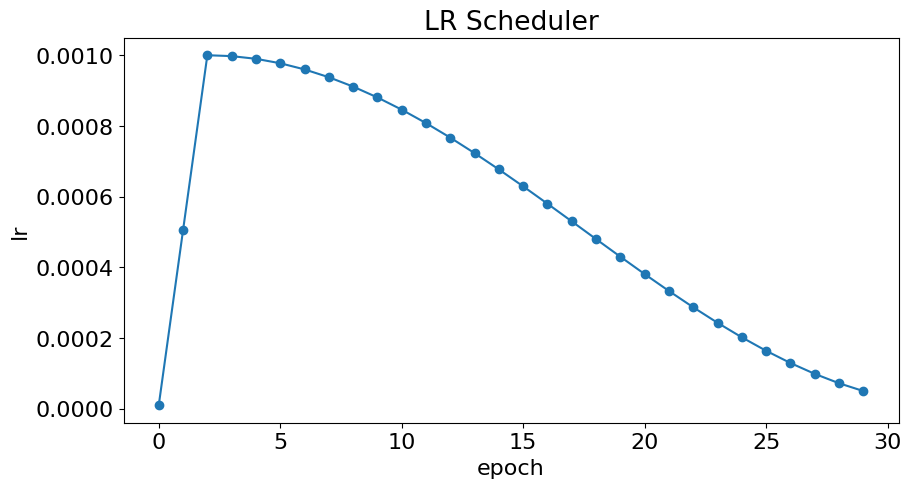

In [ ]:
def get_lr_callback(batch_size=32, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 1e-5, 1e-3, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tfk.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(batch_size, mode='cos', epochs=epochs, plot=True)
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True)
callbacks = [early_stopping, lr_cb]

In [ ]:
# Define optimizer and metrics
learning_rate = 1e-5
optimizer = tfk.optimizers.AdamW(learning_rate)
loss = tfk.losses.BinaryCrossentropy()
metrics = ['accuracy','AUC']


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = callbacks
).history

Epoch 1/30
125/125 [==============================] - 72s 382ms/step - loss: 0.6683 - accuracy: 0.6034 - auc: 0.6356 - val_loss: 0.5927 - val_accuracy: 0.7950 - val_auc: 0.8681 - lr: 1.0000e-05
Epoch 2/30
125/125 [==============================] - 44s 352ms/step - loss: 0.6795 - accuracy: 0.5924 - auc: 0.6296 - val_loss: 0.5748 - val_accuracy: 0.8544 - val_auc: 0.9300 - lr: 5.0500e-04
Epoch 3/30
125/125 [==============================] - 43s 346ms/step - loss: 0.4446 - accuracy: 0.8064 - auc: 0.8776 - val_loss: 0.3110 - val_accuracy: 0.8781 - val_auc: 0.9512 - lr: 0.0010
Epoch 4/30
125/125 [==============================] - 44s 353ms/step - loss: 0.3109 - accuracy: 0.8758 - auc: 0.9373 - val_loss: 0.3029 - val_accuracy: 0.8800 - val_auc: 0.9477 - lr: 9.9746e-04
Epoch 5/30
125/125 [==============================] - 43s 347ms/step - loss: 0.3265 - accuracy: 0.8696 - auc: 0.9301 - val_loss: 0.2750 - val_accuracy: 0.8831 - val_auc: 0.9533 - lr: 9.8987e-04
Epoch 6/30
125/125 [==============

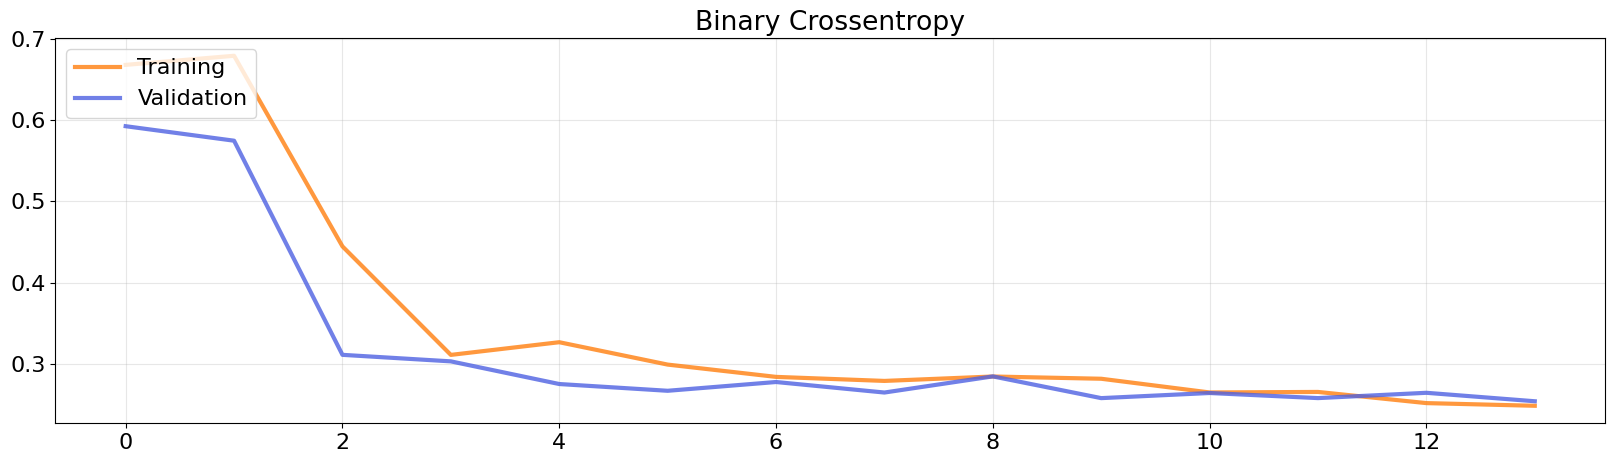

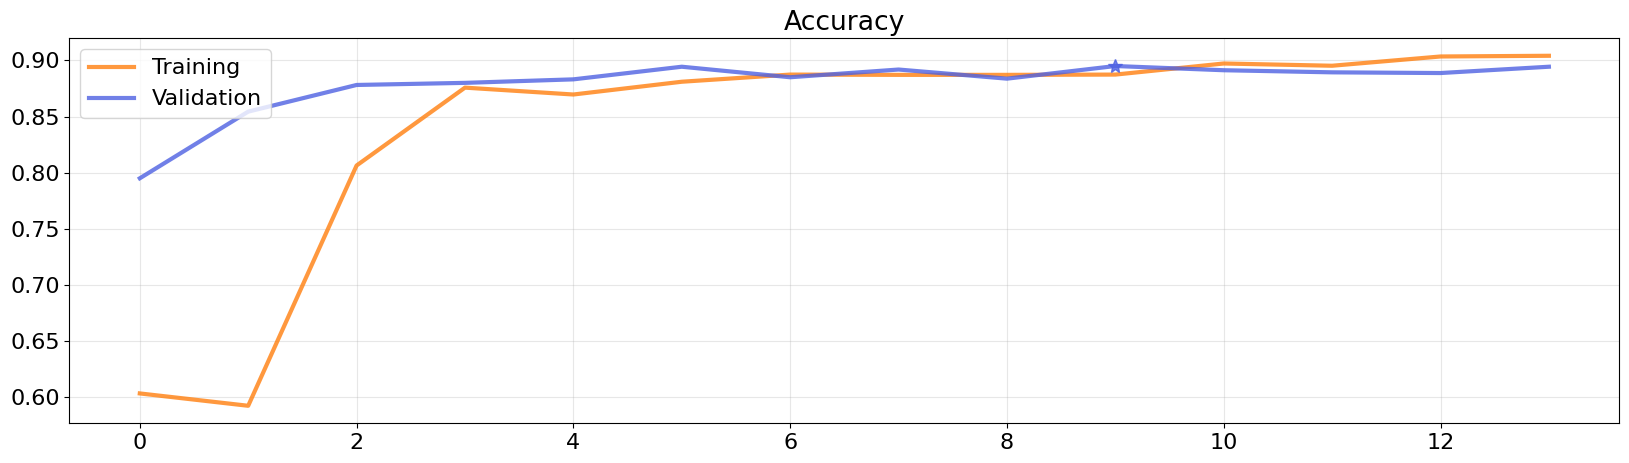

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
save = False

if save:
  model.save('VGG')

In [ ]:
out = model.evaluate(test_generator,steps=len(test_generator))

7/7 [==============================] - 1s 161ms/step - loss: 0.3151 - accuracy: 0.8825 - auc: 0.9352


In [ ]:
del model
del history

The result does not suggest a successful pretraining stage since performances are on par.